# 0.0. Instalar e importar bibliotecas y librerías necesarias

In [4]:
import torch  # Librería para operaciones de aprendizaje profundo
import torch.nn as nn  # Módulo para construcción de redes neuronales
import numpy as np  # Librería para operaciones numéricas eficientes
import pandas as pd  # Librería para manipulación y análisis de datos
import requests  # Librería para realizar solicitudes HTTP
import matplotlib.pyplot as plt


from PIL import Image, ImageFile  # Módulo para manipulación de imágenes
from datasets import Dataset
from datasets import ClassLabel as dsLabel
from datasets import Image as dsImage
from evaluate import load as load_metric  # Función para cargar métricas de evaluación
import torchvision.transforms as transforms  # Transformaciones de imágenes
from pathlib import Path  # Manejo de rutas de archivos y directorios

from transformers import AutoFeatureExtractor, SwinForImageClassification  # Modelos de transformadores
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer  # Entrenamiento de modelos de imágenes
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Cargar imágenes ligeramente corruptas

# 1.0. Preprocesamiento de los datos

## 1.1. Cargar datos

**Descripción del conjunto de datos (dataset):**

**Nombre del dataset:** NN_INPUT.feather

**Estructura:**

(4) columnas: 
* Path: nombre de la ruta de la imagen
* FUM (marca 0.0 si no es, 1.0 sí es fumalora)
* EXP (marca 0.0 si no es, 1.0 sí es explosión)
* INAC (marca 0.0 si no es, 1.0 sí es inactivo)

(21,931) filas:
* Cada fila es el nombre de la ruta de una imagen que se encuentra almacenanda en el sistema de archivos con el mismo nombre

In [5]:
# Definidiendo mi dataset (almacenando el archivo NN_INPUT.feather en data)
data = pd.read_feather("NN_INPUT.feather");
data

,Path,FUM,EXP,INAC
0,2000/abr/p0423001.jpg,0.0,0.0,1.0
1,2000/abr/p0423002.jpg,1.0,0.0,0.0
2,2000/abr/p0423003.jpg,1.0,0.0,0.0
3,2000/abr/p0424001.jpg,1.0,0.0,0.0
4,2000/abr/p0424002.jpg,1.0,0.0,0.0
...,...,...,...,...
21926,2023/mar/p0316234.jpeg,1.0,0.0,0.0
21927,2023/mar/p0317231.jpeg,1.0,1.0,0.0
21928,2023/mar/p0317232.jpeg,1.0,1.0,0.0
21929,2023/mar/p0317233.jpeg,1.0,1.0,0.0


## 1.2. Limpiar datos

* Revisar el tamaño del dataset
* Revisar si hay valores NAN, null
* Desechar filas inexistentes -> Hay filas que no tienen un Path que no hace match con las imágenes guardadas.

In [6]:
# Revisar la cantidad de imágenes
data.shape

(21931, 4)

In [7]:
# Revisar si hay valores NAN, null
data.isnull().values.any()

False

In [8]:
# Desechar las filas inexistentes
drop=[]
for i,r in data.iterrows():
    if not Path(r["Path"]).exists():
        drop.append(i)

data.drop(drop,inplace=True)
data

,Path,FUM,EXP,INAC


In [9]:
# Revisar cuántas filas (nombres de ruta) inexistentes se eliminaron
print(f"Se eliminaron {len(drop)} filas inexistentes.")

# ¡Súper! Hemos perdido una cantidad irrelevante de datos.

Se eliminaron 21931 filas inexistentes.


## 1.3. Transformación de datos
* Compatibilidad con la API datasets
* ```from_generator()``` te permite convertir los datos generados por un generador en un objeto de conjunto de datos que es compatible con todas las funcionalidades y utilidades de ```datasets.```

In [10]:
def GEN():
    for idx,row in data.iterrows():
        Image,FUM,EXP,INA = row
        
        Label="UNK"
        if FUM>0:
            if EXP>0:
                Label="EXP+FUM"
            else:
                Label="FUM"
        elif EXP>0:
            Label="EXP"
        elif INA>0:
            Label="INA"
        yield {
            "image":Image,
            "label":Label
        }

In [12]:
# Crear y darle formato a un conjunto de datos a partir de la función generadora GEN()
# Importante porque queremos trababajar con 'datasets' de HuggingFace después.

Data=Dataset.from_generator(GEN)#.cast_column("image",dsImage()).cast_column("label",dsLabel(names=["UNK","EXP","FUM","EXP+FUM","INA"]))
Data

Generating train split: 0 examples [00:00, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset

# 2.0. Entrenamiento de los datos

## 2.1. Separar los datos en:
    - entranamiento (train) -> 95%
    - evaluación (test) -> 5%

In [101]:
Data=Data.train_test_split(.05)
Data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 20824
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1097
    })
})

## 2.2. Preprocesamiento del dataset de entrenamiento
* Representación de las etiquetas
* Mapeo dibireccional entre etiquetas e identificadores numéricos

In [102]:
# Etiquetas del dataset de entrenamiento
labels = Data["train"].features["label"].names
labels

['UNK', 'EXP', 'FUM', 'EXP+FUM', 'INA']

In [103]:
# Gracias a 'ClassLabel' se crea este mapeo para representar las etiquetas de manera numérica  
label2id

{'UNK': 0, 'EXP': 1, 'FUM': 2, 'EXP+FUM': 3, 'INA': 4}

In [104]:
# Se puede hacer al inverso también
id2label

{0: 'UNK', 1: 'EXP', 2: 'FUM', 3: 'EXP+FUM', 4: 'INA'}

In [105]:
# Mapeo bidireccional entre nombres de etiquetas e identificadores numéricos

label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
    
# Ejemplo: acceder al nombre de la etiqueta asociada con el identificador numérico 3 
id2label[3]

'EXP+FUM'

# Visualizando imágenes y su etiqueta

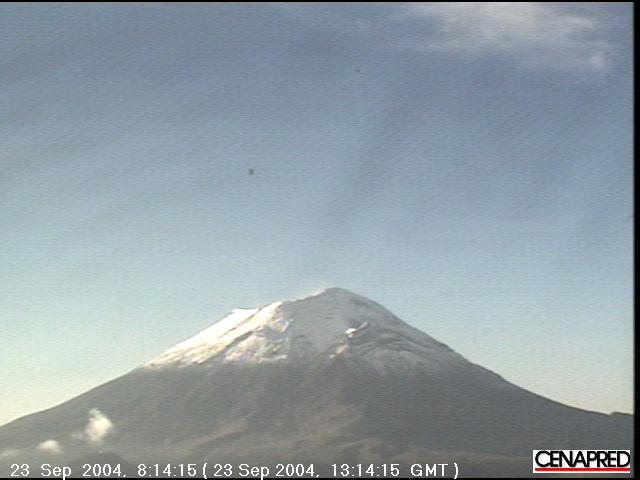

In [134]:
# Muestra la imagen en el índice 134 en el dataset de entrenamiento (train)
Data["train"][134]["image"]

In [136]:
# Muestra la etiqueta en el índice 134 en el dataset de entrenamiento (train)

print(Data["train"][134]["label"])

# Despliega las etiquetas y su identificador
print(id2label)

# ¡Es correcto, la imagen y la etiqueta hacen match! :D

4
{0: 'UNK', 1: 'EXP', 2: 'FUM', 3: 'EXP+FUM', 4: 'INA'}


# 3.0. Modelo

## 3.1. Elección de modelo
* Cargar modelo
* Cargar procesador de características para extraer y procesar las más revelantes utilizando la arq. del modelo 'swinv2'.

In [140]:
# Cargando el modelo
model_name="microsoft/swinv2-small-patch4-window16-256"

In [141]:
# Se crea un procesador de características de imágenes utilizando el modelo preentrenado especificado por 'model_name' 
image_processor = AutoFeatureExtractor.from_pretrained(model_name)

## 3.2. Preprocesamiento de las imágenes para ser usadas en el modelo

Mediante diferentes transformaciones se asegura que las imágenes de entrada estén en el formato y la escala adecuados antes de ser utilizadas para entrenar o evaluar el modelo.

In [155]:
# Importar transformaciones específicas de la biblioteca torchvision para el preprocesamiento de imágenes

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

# Crear una normalización para las imágenes utilizando las estadísticas de imagen del procesador de características
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)


# Determinar el tamaño y tamaño de recorte de las imágenes según las especificaciones del procesador de imágenes
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None # No se establece un tamaño máximo
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")
    
else:
    # Establecer valores predeterminados o manejar el error
    size = (default_height, default_width)  # Valores predeterminados
    crop_size = size
    max_size = None

# Definir transformaciones de preprocesamiento para el dataset de entrenamiento
train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

# Definir transformaciones de preprocesamiento para el dataset de validación
val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

In [161]:
# Preprocesar un batch de ejemplos de entrenamiento
def preprocess_train(example_batch):

    # Se aplica 'train_transforms' a cada imagen en el batch y se asigna el resultado a "pixel_values"
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

In [168]:
# Preprocesar un batch de ejemplos de validación
def preprocess_val(example_batch):
    
    # Se aplica 'val_transforms' a cada imagen en el batch y se asigna el resultado a "pixel_values"
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [167]:
# Se asigna el conjunto de datos de entrenamiento del objeto 'Data' a la variable 'train_ds'
train_ds = Data['train']

# Se asigna el conjunto de datos de prueba del objeto 'Data' a la variable 'val_ds'
val_ds = Data['test']

In [166]:
# Se configuran las transformaciones predefinidas 'preprocess_train' y 'preprocess_val' en los conjuntos de datos de entrenamiento y prueba

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Aplicar las transformaciones predefinidas a los conjuntos de datos, asegura que las imágenes se procesen de manera consistente y adecuada antes de ser utilizadas en las etapas de entrenamiento y evaluación.

In [173]:
# Visualizando cómo luce el dataset de entrenamiento
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 20824
})

## 3.3. Creación del modelo

In [174]:
# Crear un modelo para la clasificación de imágenes utilizando el modelo preentrenado especificado
model = AutoModelForImageClassification.from_pretrained(
    model_name, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # se proporciona esto en caso de que estés planeando hacer fine-tune a un checkpoint que ya está fine-tuned
)

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-small-patch4-window16-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [181]:
# Cargar métrica de "accuracy"
metric = load_metric("accuracy")

# Cargar otras-diferentes métricas

precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

In [182]:
# Extraer el nombre del modelo a partir de la ruta y crear argumentos de entrenamiento
model_name_b = model_name.split("/")[-1]  # Extraer el nombre del modelo de la ruta

# Configurar los argumentos de entrenamiento
args = TrainingArguments(
    f"{model_name_b}-finetuned-popocatepetl",  # Nombre del directorio para el modelo fine-tuned
    remove_unused_columns=False,
    evaluation_strategy="epoch",  # Evaluar después de cada época
    save_strategy="epoch",  # Guardar después de cada época
    learning_rate=5e-5,
    fp16=True,  # Utilizar precisión de 16 bits
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,  # Número de épocas de entrenamiento
    warmup_ratio=0.1,  # Proporción de pasos de calentamiento
    logging_steps=10,  # Intervalo para registrar información
    load_best_model_at_end=True,  # Cargar el mejor modelo al final del entrenamiento
    metric_for_best_model="accuracy",  # Utilizar la métrica de "accuracy" para el mejor modelo
    push_to_hub=False,  # No subir a Hugging Face Model Hub
    report_to=[],  # No informar a ningún servicio
)

In [183]:
def compute_metrics(eval_pred):
    """Calcula la precisión en un batch de predicciones"""
    
    # Calcula las predicciones utilizando el índice de la clase con mayor probabilidad
    predictions = np.argmax(eval_pred.predictions, axis=1)
    
    # Calcula la métrica (en este caso, la métrica definida previamente) utilizando las predicciones y las etiquetas reales
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)


In [184]:
def collate_fn(examples):
    """Función de agrupación utilizada durante la creación de batch de ejemplos"""
    
    # Apila los valores de píxeles de todas las imágenes en el lote
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    
    # Crea un tensor con las etiquetas correspondientes a cada ejemplo en el lote
    labels = torch.tensor([example["label"] for example in examples])
    
    # Retorna un diccionario que contiene los valores de píxeles y las etiquetas agrupados
    return {"pixel_values": pixel_values, "labels": labels}

In [185]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=704x480>,
 'label': 3,
 'pixel_values': tensor([[[ 0.5878,  0.5878,  0.5707,  ...,  0.5022,  0.5364,  0.5193],
          [ 0.5878,  0.5878,  0.5707,  ...,  0.5022,  0.5536,  0.5193],
          [ 0.5878,  0.5878,  0.5707,  ...,  0.5022,  0.5707,  0.5364],
          ...,
          [-1.6213, -1.6213, -1.6213,  ..., -1.6727, -1.6555, -1.6555],
          [-1.6555, -1.6384, -1.6042,  ..., -1.6727, -1.6555, -1.6555],
          [-1.6384, -1.6555, -1.6042,  ..., -1.6727, -1.6727, -1.6727]],
 
         [[ 1.2381,  1.2381,  1.2206,  ...,  1.0980,  1.0805,  1.0630],
          [ 1.2381,  1.2381,  1.2206,  ...,  1.0980,  1.0980,  1.0630],
          [ 1.2381,  1.2381,  1.2206,  ...,  1.0980,  1.1155,  1.0805],
          ...,
          [-1.5280, -1.5280, -1.5280,  ..., -1.5805, -1.5630, -1.5630],
          [-1.5630, -1.5455, -1.5105,  ..., -1.5805, -1.5630, -1.5630],
          [-1.5455, -1.5630, -1.5105,  ..., -1.5805, -1.5805, -1.5805]]

Primer ejemplo en el conjunto de datos train_ds. 

train_ds contiene ejemplos de imágenes y sus etiquetas correspondientes.

train_ds[0]: primer ejemplo en este conjunto de datos, que generalmente incluye la imagen y su etiqueta. 
Un diccionario con claves "image", "label", "pixel_values", que te proporcionan la imagen y la etiqueta y los pixeles de la imagen.

In [188]:
# Crear un objeto Trainer para la fase de entrenamiento y evaluación del modelo

trainer = Trainer(
    model,  # Modelo a entrenar y evaluar
    args,  # Argumentos de entrenamiento configurados previamente
    train_dataset=train_ds,  # Conjunto de datos de entrenamiento
    eval_dataset=val_ds,  # Conjunto de datos de validación/evaluación
    tokenizer=image_processor,  # Procesador de imágenes para tokenizar
    compute_metrics=compute_metrics,  # Función para calcular métricas de evaluación
    data_collator=collate_fn,  # Función para agrupar ejemplos en batches
)

In [190]:
# Iniciar el proceso de entrenamiento utilizando el objeto Trainer

train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.762600,0.649445,0.747493
2,0.641400,0.570782,0.769371
3,0.478900,0.546586,0.793984
4,0.634600,0.533760,0.791249
5,0.510600,0.556122,0.788514
6,0.549800,0.525327,0.806746
7,0.501300,0.504734,0.810392
8,0.491200,0.511964,0.810392
9,0.451800,0.520961,0.811304
10,0.428800,0.524772,0.814950


Se inicia el proceso de entrenamiento del modelo utilizando el objeto trainer que se creó previamente.
* ```train_results``` almacenará los resultados del proceso de entrenamiento (información sobre la pérdida, tiempo de entrenamiento, tasa de aprendizaje, etc)
*```train()``` del objeto ```trainer``` llevará a cabo el entrenamiento del modelo utilizando los datos del conjunto de entrenamiento ```(train_ds)``` según la configuración de los argumentos ```(args)```.  Durante el proceso, el modelo ajustará sus pesos y aprenderá a partir de los ejemplos de entrenamiento. Al final del entrenamiento, los resultados se almacenarán en la variable ```train_results```, y se podrá usar esta información para evaluar cómo el modelo ha mejorado a lo largo del proceso de entrenamiento.

In [191]:
# Guardar el modelo entrenado y registrar métricas y estado del entrenamiento

trainer.save_model()  # Guardar el modelo entrenado
trainer.log_metrics("train", train_results.metrics)  # Registrar métricas de entrenamiento
trainer.save_metrics("train", train_results.metrics)  # Guardar métricas de entrenamiento
trainer.save_state()  # Guardar el estado del entrenamiento

***** train metrics *****
  epoch                    =          10.0
  total_flos               = 11201780881GF
  train_loss               =        0.5609
  train_runtime            =    1:17:26.76
  train_samples_per_second =        44.814
  train_steps_per_second   =         1.401


In [192]:
# Extraer el nombre base del modelo preentrenado
model_name_b = model_name.split("/")[-1]

# Cargar el modelo finetuned a partir del nombre base y configuraciones
model = AutoModelForImageClassification.from_pretrained(
    f"{model_name_b}-finetuned-popocatepetl",  # Cargar el modelo finetuned
    label2id=label2id,  # Configuración de mapeo de etiquetas a IDs
    id2label=id2label,  # Configuración de mapeo de IDs a etiquetas
    ignore_mismatched_sizes=True,  # Ignorar tamaños incompatibles (si es necesario)
).to("cuda")  # Mover el modelo a la GPU (si está disponible)

In [193]:
# Suprimir la notación científica -> imprimir números en coma flotante
np.set_printoptions(suppress=True)

In [1]:
# Seleccionar un índice aleatorio del conjunto de prueba
idx = np.random.choice(len(Data["test"]))

# Obtener la fila correspondiente al índice seleccionado
row = Data["test"][idx]

# Procesar la imagen de entrada y obtener las predicciones del modelo
inputs = image_processor(images=row["image"], return_tensors="pt")["pixel_values"].to("cuda")
outputs = model(pixel_values=inputs)
logits = outputs.logits

# Imprimir las logits y las probabilidades
print("LOGITS:", logits)

# Calcular las probabilidades ~suavizadas~
probabilities = nn.functional.softmax(logits, dim=-1)
probabilities = probabilities.detach().cpu().numpy().flatten()
print("LOGITS CON SUAVITEL:", probabilities)
print("LA SUMA", probabilities.sum())

# Imprimir el mapeo de etiquetas a IDs
print(model.config.label2id)

# Obtener el índice de la clase predicha
predicted_class_idx = logits.argmax(-1).item()

# Imprimir la clase predicha y la clase real
print("Predicted class:", model.config.id2label[predicted_class_idx])
print("Real class:", model.config.id2label[row["label"]])

# Imprimir las probabilidades en porcentaje
print(probabilities * 100)

# Devolver la imagen original
row["image"]

NameError: name 'np' is not defined

/tmp/ipykernel_5571/2098687669.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


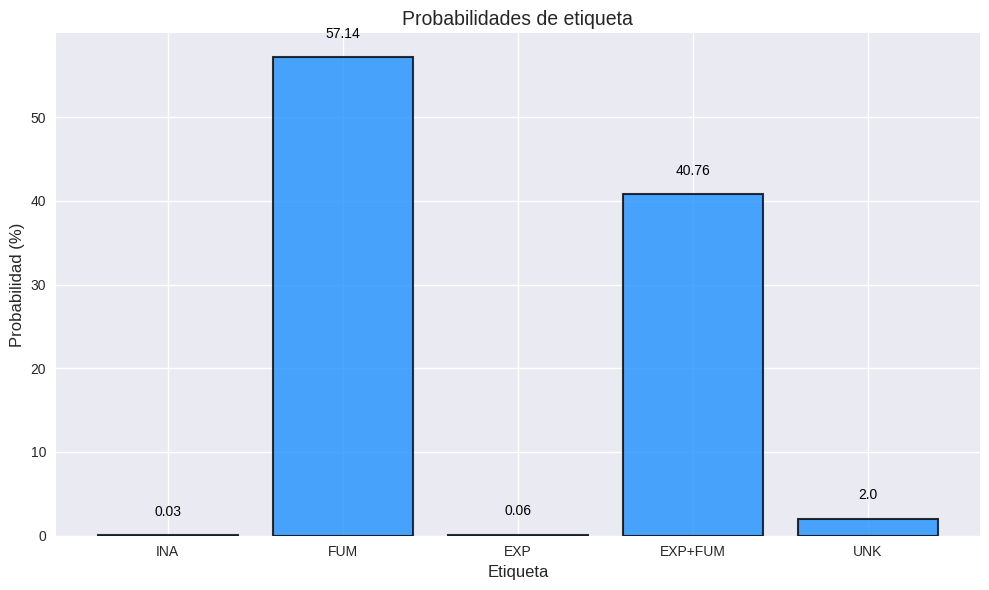

In [198]:
# Establecer un estilo para la gráfica
plt.style.use('seaborn')

# Crear una figura para el gráfico de barras
fig = plt.figure(figsize=(10, 6))

# Etiquetas en el eje x
display_labels = ["INA", "FUM", "EXP", "EXP+FUM", "UNK"]

# Crear el gráfico de barras
bars = plt.bar(display_labels, [probabilities[model.config.label2id[x]] * 100 for x in display_labels], color='dodgerblue', edgecolor='black', linewidth=1.5, alpha=0.8)

# Agregar etiquetas con las probabilidades en las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

# Etiquetas para los ejes y título del gráfico
plt.xlabel("Etiqueta", fontsize=12)
plt.ylabel("Probabilidad (%)", fontsize=12)
plt.title("Probabilidades de etiqueta", fontsize=14)

# Ajustar los márgenes y mostrar el gráfico
plt.tight_layout()
plt.show()